In [1]:
import os
import sys
import pickle
import numpy as np

# sys.path.append('/n/home04/aboesky/berger/Weird_Galaxies')
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

# Get best model

In [2]:
grid_results = []
# for fname in os.listdir('/n/home04/aboesky/berger/Weird_Galaxies/hp_no_photoz_grid_search/results'):
for fname in os.listdir('/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper/hp_no_photoz_grid_search/results'):
    with open(f'/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper/hp_no_photoz_grid_search/results/{fname}', 'rb') as f:
    # with open(f'/n/home04/aboesky/berger/Weird_Galaxies/hp_no_photoz_grid_search/results/{fname}', 'rb') as f:
        grid_results.append(pickle.load(f))

In [3]:
# Get the best loss
best_loss = {'test': np.inf, 'train': np.inf}
best_params = None
for params, loss in grid_results:
    if np.min(loss['test']) < np.min(best_loss['test']):
        best_params = params
        best_loss = loss

print(f'The best parameter combination in our grid search are:\n\nbatch_size, nodes_per_layer, num_linear_output_layers, learning_rate\n{best_params[::-1]}')

The best parameter combination in our grid search are:

batch_size, nodes_per_layer, num_linear_output_layers, learning_rate
[4096, [18, 13, 8, 4], 3, 0.01]


# Plots

## Loss v. Epoch

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_23563/2793020348.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.yscale('log')


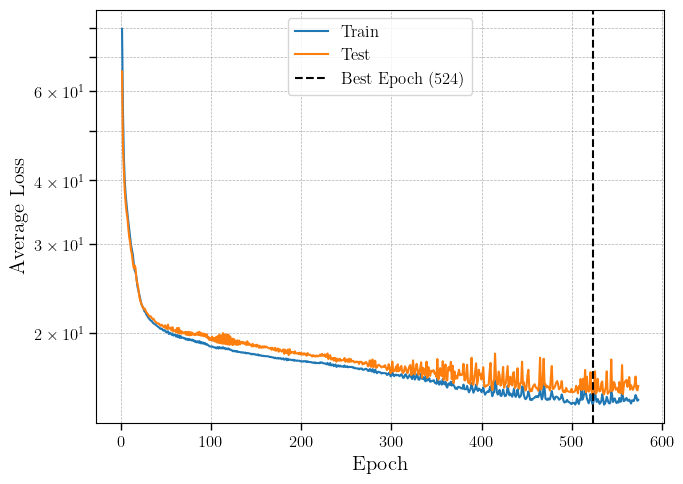

In [4]:
from matplotlib.ticker import LogLocator

plt.figure(figsize=(7, 5))
epochs = np.arange(1, len(best_loss['train']) + 1, 1)
plt.yscale('log')
plt.plot(epochs, best_loss['train'], label='Train')
plt.plot(epochs, best_loss['test'], label='Test')

# Make ticks bigger
plt.tick_params(axis='y', which='major', length=7, width=1)  # Adjust major tick size
plt.tick_params(axis='x', which='major', length=5, width=1)  # Adjust major tick size
plt.tick_params(axis='y', which='minor', length=5, width=1)  # Adjust minor tick size
best_epoch = np.argmin(best_loss['test']) + 1
plt.axvline(x=best_epoch, linestyle='--', color='k', label=f'Best Epoch ({best_epoch})')
plt.grid(True, which="both", ls="--", lw=0.5)

plt.ylabel('Average Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend()
plt.tight_layout()
# plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/best_loss_v_epoch.png', dpi=1000)
plt.show()

In [5]:
arg_test_min = np.argmin(best_loss['test'])
print(f'Minimum loss values:\n\ttest={best_loss["test"][arg_test_min]}\n\ttrain={best_loss["train"][arg_test_min]}')

Minimum loss values:
	test=15.130186523238656
	train=14.565332106489302


## Real v. Pred

In [4]:
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper')
import torch
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve
from neural_net import resume, CustomLoss, get_model, normalize_arr
from host_prop_nn import load_and_preprocess
PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

In [5]:
# Get best model based on grid search
n_epochs = 1000
nodes_per_layer = [18, 13, 8, 4]
num_linear_output_layers = 3
learning_rate = 0.01
batch_size = 4096
torch.set_default_dtype(torch.float64)
model = get_model(num_inputs=18, num_outputs=3, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
resume(model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/host_prop_no_photozs.pkl')
model.eval()

Sequential(
  (input): Linear(in_features=18, out_features=18, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=18, out_features=13, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=13, out_features=8, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=8, out_features=4, bias=True)
  (act_2): ReLU()
  (pre_output0): Linear(in_features=4, out_features=4, bias=True)
  (pre_output1): Linear(in_features=4, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)

In [6]:
"""Load and preprocess our data."""
######################## IMPORT DATA ########################
with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_photometry.pkl'), 'rb') as f:
    all_photo = pickle.load(f)
photo = all_photo['data']
photo_err = all_photo['data_err']

# Take log of the fluxes to make the distributions better
photo_err = np.abs(photo_err / (photo * np.log(10)))
photo = np.log10(photo)

with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_cat.pkl'), 'rb') as f:
    all_cat = pickle.load(f)
cat_photoz = all_cat['data']
all_cat['data_err'][:, 2][all_cat['data_err'][:, 2] == 0.01] = 0.001 # Drop the spectroscopic errors down from the already low error
cat_err_photoz = all_cat['data_err']

# Drop speczs
specz_mask = all_cat['data_err'][:, 2] == 0.001
photo_photoz = photo[~specz_mask]
photo_err_photoz = photo_err[~specz_mask]
cat_photoz = cat_photoz[~specz_mask]
cat_err_photoz = cat_err_photoz[~specz_mask]

# Filter out z>1
z_local_mask = cat_photoz[:, 2] <= 1
# add additional filter for potentially bad bands
z_local_mask &= cat_photoz[:, 2] > 0.0126
photo_photoz = photo_photoz[z_local_mask]
photo_err_photoz = photo_err_photoz[z_local_mask]
cat_photoz = cat_photoz[z_local_mask]
cat_err_photoz = cat_err_photoz[z_local_mask]

# Drop bad bands (ch1, mips, pacs100)
# good_bands = [i for i, t in enumerate(all_photo['sorted_filters']) if t not in ['CH1', 'MIPS24', 'MIPS70', 'PACS100']]
# all_photo['sorted_filters'] = [all_photo['sorted_filters'][i] for i in good_bands]
# all_photo['sorted_wavelengths'] = [all_photo['sorted_wavelengths'][i] for i in good_bands]
# photo = photo[:, good_bands]
# photo_err = photo_err[:, good_bands]

# Log transform the redshifts
cat_err_photoz[:, 2] = np.abs(cat_err_photoz[:, 2] / (np.log(10) * cat_photoz[:, 2]))
cat_photoz[:, 2] = np.log10(cat_photoz[:, 2])

# ######################## PRE PROCESSING ########################
# # Filter out nans
nan_mask = np.isnan(cat_photoz).any(axis=1)
# photo_norm, photo_mean, photo_std, photo_err_norm = normalize_arr(photo[~nan_mask], errors=photo_err[~nan_mask])
# cat_norm, cat_mean, cat_std, cat_err_norm = normalize_arr(cat[~nan_mask], errors=cat_err[~nan_mask])
# print('HEEERRRREE', cat_norm)
# print(cat_mean)
# LOG.info('Photo stats:\n \tmean = %s\n \tstd = %s', photo_mean, photo_std)
# LOG.info('Catalog stats:\n \tmean = %s\n \tstd = %s', cat_mean, cat_std)
# LOG.info('Length = %i', len(photo))

all_cat, all_photo, photo_train, photo_test, cat_train, cat_test, photo_err_train, photo_err_test, cat_err_train, \
    cat_err_test, photo_norm, photo_mean, photo_std, photo_err_norm, cat_norm, cat_mean, cat_std, cat_err_norm = load_and_preprocess()

photo_norm_photoz, photo_mean, photo_std, photo_err_norm_photoz = normalize_arr(photo_photoz[~nan_mask], errors=photo_err_photoz[~nan_mask], mean=photo_mean, std=photo_std)
cat_norm_photoz, cat_mean_photoz, cat_std_photoz, cat_err_norm_photoz = normalize_arr(cat_photoz[~nan_mask], errors=cat_err_photoz[~nan_mask], mean=cat_mean, std=cat_std)

2024-09-09 18:13:44,026 - host_prop_nn.py - INFO - Importing photometry data
2024-09-09 18:13:46,359 - host_prop_nn.py - INFO - Fixing the error for 96514 objects
2024-09-09 18:13:46,375 - host_prop_nn.py - INFO - Dropping 2594528 / 2691042 photozs!
2024-09-09 18:13:46,486 - host_prop_nn.py - INFO - Importing photometry data
2024-09-09 18:13:46,550 - host_prop_nn.py - INFO - Photo stats:
 	mean = [-2.08274563 -1.85131022 -1.91613353 -1.66802481 -1.64246513 -1.25522173
  0.25350126  0.83653875  1.17192861  0.57818982  1.1259272   1.01584674
  1.04199348 -1.88944646 -1.61961707 -1.34950203 -2.11908458 -2.15331442]
 	std = [0.62591803 0.58210564 0.62691966 0.58754192 0.59550117 0.68815349
 1.25305475 1.69616504 0.35624714 1.30944343 0.66719213 0.54067956
 0.55135835 1.86403438 1.66563717 1.50029875 0.55361615 0.63603353]
2024-09-09 18:13:46,551 - host_prop_nn.py - INFO - Catalog stats:
 	mean = [ 9.99878348 -0.13575662 -0.3170729 ]
 	std = [0.83429481 1.04090293 0.26033958]
2024-09-09 18:

HEEERRRREE [[ 0.68735514 -3.73327686 -2.95426938]
 [-1.68488085 -0.31710368 -3.29128709]
 [ 1.28118105 -1.88014654 -1.59697336]
 ...
 [-0.91752005 -0.17525813 -0.08646464]
 [-3.6916955  -2.32110538 -3.94510607]
 [-0.55604096 -1.49926118 -0.48175502]]
[ 9.99878348 -0.13575662 -0.3170729 ]


In [7]:
# photo_train, photo_test, cat_train, cat_test, photo_err_train, photo_err_test, cat_err_train, cat_err_test = \
#     train_test_split(photo_norm, cat_norm, photo_err_norm, cat_err_norm, shuffle=True, test_size=0.2, random_state=22)

# Predict attributes for the galaxies that have SNe
model.eval()
gal_props_pred: torch.Tensor = model(torch.from_numpy(photo_test))
gal_props_pred_untrans = gal_props_pred.detach().numpy()
num_specz = gal_props_pred_untrans.shape[0]

# Predict the photoz values
gal_props_pred_photoz: torch.Tensor = model(torch.from_numpy(photo_norm_photoz))
gal_props_pred_untrans_photoz = gal_props_pred_photoz.detach().numpy()
num_photoz = gal_props_pred_untrans_photoz.shape[0]

# Stack 'em
gal_props_pred_untrans = np.vstack((gal_props_pred_untrans, gal_props_pred_untrans_photoz))
cat_test = np.vstack((cat_test, cat_norm_photoz))

In [8]:
# photo_z_mask = cat_err_test[:, 2] > 0.01
# print(np.sum(photo_z_mask))
all_mask = np.ones(cat_test.shape[0]) == 1
photo_z_mask = np.hstack((np.zeros(num_specz), np.ones(num_photoz))) == 1

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_25051/3367293493.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figsize as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_25051/3367293493.py:17: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_25051/3367293493.py:40: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_25051/3367293493.py:41: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, cax=cbar_ax, fr

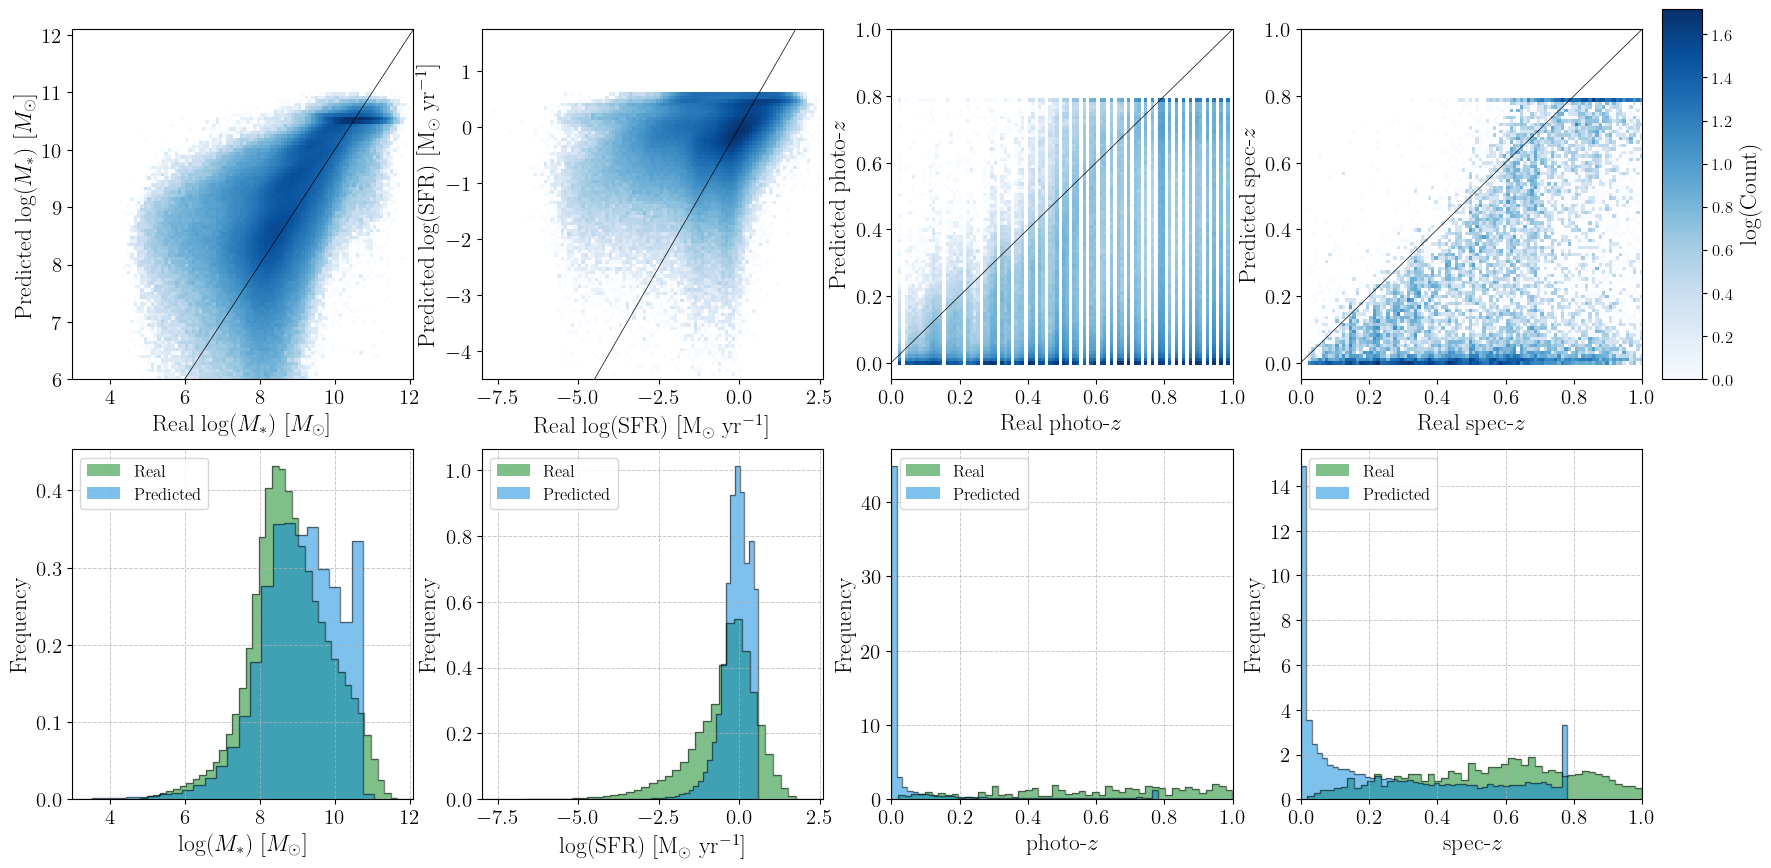

In [9]:
# Real v pred heatmaps
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust figsize as needed
pred = gal_props_pred_untrans * cat_std + cat_mean
real = cat_test * cat_std + cat_mean
real[:, 2] = 10**real[:, 2]
pred[:, 2] = 10**pred[:, 2]
params = [r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \ \rm{yr}^{-1}]$', r'photo-$z$', r'spec-$z$']
xlims = [(3, 12.1), (-8, 2.6), (0, 1), (0, 1)]
ylims = [(6, 12.1), (-4.5, 1.75), (-0.05, 1), (-0.05, 1)]
masks = [all_mask, all_mask, photo_z_mask, ~photo_z_mask]

for i, (param, xlim, ylim, ax, mask) in enumerate(zip(params, xlims, ylims, axes[0], masks)):
    if i == 3:
        i -= 1
    heatmap, xedges, yedges = np.histogram2d(real[:, i][mask], pred[:, i][mask], bins=(100, 100), range=[xlim, ylim])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
    ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(fr'Real {param}', fontsize=17)
    ax.set_ylabel(fr'Predicted {param}', fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=15)

for i, (param, ax, lim, mask) in enumerate(zip(params, axes[1], xlims, masks)):
    if i == 3:
        i -= 1
    ax.hist(real[:, i][mask], label='Real', alpha=0.5, density=True, bins=50, color='#008114')
    ax.hist(real[:, i][mask], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.hist(pred[:, i][mask], label='Predicted', alpha=0.5, density=True, bins=50, color='#0084DD')
    ax.hist(pred[:, i][mask], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.set_xlabel(param, fontsize=17)
    ax.set_ylabel(r'Frequency', fontsize=17)
    ax.legend(loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)
    ax.set_xlim(lim)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, fraction=1.5)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.subplots_adjust(right=0.91)
# plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/host_prop_real_v_preds.pdf', bbox_inches='tight')
plt.show()

In [10]:
"""Load and preprocess our data."""
######################## IMPORT DATA ########################
with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_photometry.pkl'), 'rb') as f:
    all_photo = pickle.load(f)
photo = all_photo['data']
photo_err = all_photo['data_err']

# Take log of the fluxes to make the distributions better
photo_err = np.abs(photo_err / (photo * np.log(10)))
photo = np.log10(photo)

with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_cat.pkl'), 'rb') as f:
    all_cat = pickle.load(f)
cat = all_cat['data']
all_cat['data_err'][:, 2][all_cat['data_err'][:, 2] == 0.01] = 0.001 # Drop the spectroscopic errors down from the already low error

# Drop photozs
# specz_mask = all_cat['data_err'][:, 2] == 0.001

# cat = cat[specz_mask]
cat_err = all_cat['data_err']#[specz_mask]
# photo = photo[specz_mask]
# photo_err = photo_err[specz_mask]

# Filter out z>1
z_local_mask = cat[:, 2] <= 1
# add additional filter for potentially bad bands
z_local_mask &= cat[:, 2] > 0.0126
photo = photo[z_local_mask]
photo_err = photo_err[z_local_mask]
cat = cat[z_local_mask]
cat_err = cat_err[z_local_mask]

# Drop bad bands (ch1, mips, pacs100)
# good_bands = [i for i, t in enumerate(all_photo['sorted_filters']) if t not in ['CH1', 'MIPS24', 'MIPS70', 'PACS100']]
# all_photo['sorted_filters'] = [all_photo['sorted_filters'][i] for i in good_bands]
# all_photo['sorted_wavelengths'] = [all_photo['sorted_wavelengths'][i] for i in good_bands]
# photo = photo[:, good_bands]
# photo_err = photo_err[:, good_bands]

# Log transform the redshifts
cat_err[:, 2] = np.abs(cat_err[:, 2] / (np.log(10) * cat[:, 2]))
cat[:, 2] = np.log10(cat[:, 2])

######################## PRE PROCESSING ########################
# Filter out nans
nan_mask = np.isnan(cat).any(axis=1)
photo_norm, photo_mean, photo_std, photo_err_norm = normalize_arr(photo[~nan_mask], errors=photo_err[~nan_mask])
cat_norm, cat_mean, cat_std, cat_err_norm = normalize_arr(cat[~nan_mask], errors=cat_err[~nan_mask])
print('HEEERRRREE', cat_norm)
print(cat_mean)
print(f'Photo stats:\n \tmean = {photo_mean}\n \tstd = {photo_std}')
print(f'Catalog stats:\n \tmean = {cat_mean}\n \tstd = {cat_std}')


HEEERRRREE [[ 0.69879328  1.44090157  0.33654284]
 [-0.5611702   0.68871811  0.70004105]
 [-0.49142539  0.80762344  0.54258619]
 ...
 [ 0.56822286 -1.04936127  0.63778058]
 [-1.45187574 -0.5911653   0.03264011]
 [-0.55335552 -0.57962198 -0.59064947]]
[ 8.87088133 -0.46037044 -0.30782959]
Photo stats:
 	mean = [-2.87849839 -2.79518071 -2.78359176 -2.63765973 -2.66592091 -1.33953981
  0.06383305  0.67075717  1.34771103  0.91141463  1.33652476  1.2116005
  1.32755404 -2.41376848 -2.20197162 -1.97797089 -3.03436027 -3.03643454]
 	std = [0.63162979 0.70187988 0.68387317 0.72578209 0.7777774  0.88136263
 1.62222597 2.06392269 0.43210206 1.36265575 0.50050502 0.43821229
 0.46058673 2.21595863 2.13270738 2.02278681 0.67246779 0.70040306]
Catalog stats:
 	mean = [ 8.87088133 -0.46037044 -0.30782959]
 	std = [1.08494612 1.04024203 0.31434106]


# Fractional Error

In [90]:
# Get the median fractional error
frac_errs = []
errs = []
for i, (r, p) in enumerate(zip(real.T, pred.T)):
    # frac_errs.append(np.abs((r - p) / r))
    frac_errs.append(np.abs((r - p) / np.max((r, p))))
    errs.append(np.abs((r - p)))

errs = np.array(errs)
frac_errs = np.array(frac_errs)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72126/3242540889.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(photoz_frac_err, bins=np.linspace(0, 5, num=50))


Photo-z fractional error = 0.18382066591655388
Photo-z  error = 0.11071792311154513


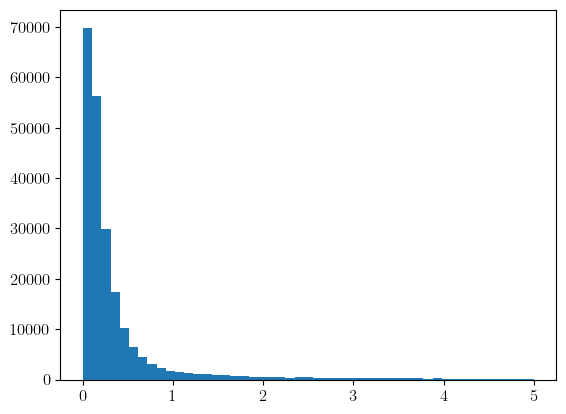

In [99]:
photoz_frac_err = np.abs((real[:, 2][photo_z_mask] - pred[:, 2][photo_z_mask]) / real[:, 2][photo_z_mask])
photoz_err = np.abs((real[:, 2][photo_z_mask] - pred[:, 2][photo_z_mask]))
plt.hist(photoz_frac_err, bins=np.linspace(0, 5, num=50))
print(f'Photo-z fractional error = {np.median(photoz_frac_err)}')
print(f'Photo-z  error = {np.median(photoz_err)}')

In [92]:
print(np.nansum(frac_errs[0] > 2))
print(np.nansum(frac_errs[1] > 10000))
print(np.nansum(frac_errs[2] > 100))

0
0
0


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_72126/2393434733.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(errs[i], bins=50)


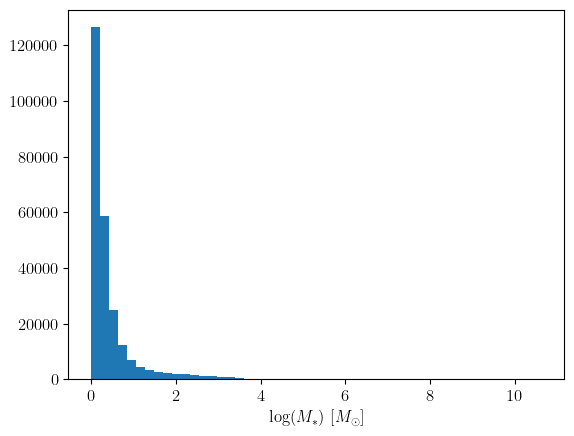

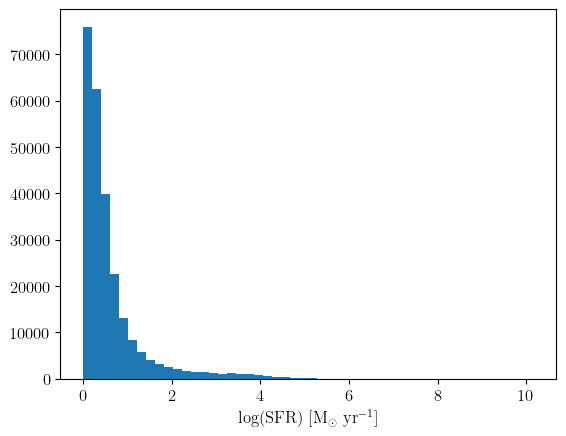

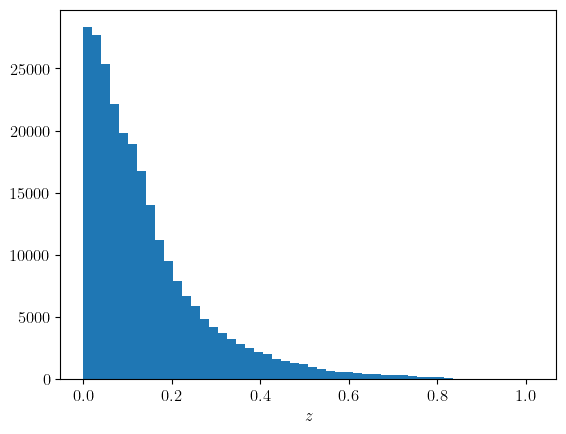

In [96]:
params = [r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \ \rm{yr}^{-1}]$', r'$z$']
xmax = [2, 20, 20]
for i, (param, xm) in enumerate(zip(params, xmax)):
    plt.hist(errs[i], bins=50)
    plt.xlabel(param)
    plt.show()

In [97]:
print(f'Order of results is {params}')
print(f'Fractional Error:\n\tmean = {np.mean(frac_errs, axis=1).round(4)} \n\tmedian = {np.median(frac_errs, axis=1).round(4)} \n\tstdev = {np.std(frac_errs, axis=1).round(4)}\n\n')
print(f'Error:\n\tmean = {np.mean(errs, axis=1).round(4)} \n\tmedian = {np.median(errs, axis=1).round(4)} \n\tstdev = {np.std(errs, axis=1).round(4)}\n\n')

print(f'Measured Uncertainties:\n\tmean = \t{np.mean(cat_err_test, axis=0).round(4)}\n\tmedian = {np.median(cat_err_test, axis=0).round(4)}\n\tstdev = {np.std(cat_err_test, axis=0).round(4)}\n\n')

print(f'Prediction RMSE = {np.sqrt(np.mean(errs**2, axis=1).round(4)).round(4)}')
print(f'Measured uncertainty/true value = {np.abs(np.mean(cat_err_test / cat_test, axis=0).round(4))}')

Order of results is ['$\\log(M_*) \\ [M_\\odot]$', '$\\log(\\rm{SFR}) \\ [M_\\odot \\ \\rm{yr}^{-1}]$', '$z$']
Fractional Error:
	mean = [0.0333 0.2233 0.1436] 
	median = [0.0173 0.1339 0.105 ] 
	stdev = [0.0466 0.2781 0.1363]


Error:
	mean = [0.4092 0.6015 0.1436] 
	median = [0.2121 0.3607 0.105 ] 
	stdev = [0.5722 0.7491 0.1363]


Measured Uncertainties:
	mean = 	[0.1839 0.3254 1.4333]
	median = [0.1626 0.2399 0.5543]
	stdev = [0.102  0.2865 1.9451]


Prediction RMSE = [0.7035 0.9607 0.198 ]
Measured uncertainty/true value = [0.3975 0.251  0.8293]
